## Notebook setup

In [1]:
import os
import io
import warnings
import datetime
import numpy as np
import base64
import pytz
import pandas as pd
import matplotlib

import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline

from IPython.display import HTML

# import sys
# sys.path.append('../../')

from openbb_terminal.api import widgets
from openbb_terminal.api import helper
from openbb_terminal.api import openbb
from openbb_terminal.api import Portfolio
from openbb_terminal.helper_classes import TerminalStyle

%matplotlib inline
matplotlib_inline.backend_inline.set_matplotlib_formats("svg")
warnings.filterwarnings("ignore")

# Detect if prediction capabilities are present. If they are not, disable prediction in the rest of the script
# so that the report can still be generated without prediction results.
# predictions = True
# try:
#     openbb.stocks.pred.models
# except Exception as e:
#     predictions = False

# TODO Fix predictions virtual path on api refactored

predictions = False

WARNING! Breaking changes incoming! Especially avoid using kwargs, since some of them will change.
You can try <link> branch with the latest changes.


### Header

In [2]:
try:
    theme = TerminalStyle("dark", "dark", "dark")
except:
    pass
stylesheet = widgets.html_report_stylesheet()
with open("OpenBB_reports_logo.png", "rb") as image_file:
    openbb_image_encoded = base64.b64encode(image_file.read())

user_time_zone = pytz.timezone(helper.get_user_timezone())

In [3]:
# Parameters that will be replaced when calling this notebook
symbol = ""
report_name = "portfolio_report"

In [4]:
author = "Diogo Sousa"
report_title = f"Portfolio report"
report_date = pd.Timestamp.now(tz=user_time_zone).strftime("%d %B, %Y")
report_time = pd.Timestamp.now(tz=user_time_zone).strftime("%H:%M")
report_timezone = pd.Timestamp.now(tz=user_time_zone).tzinfo
report_title, report_date, report_time, report_timezone

('Portfolio report',
 '12 September, 2022',
 '14:22',
 <DstTzInfo 'America/New_York' EDT-1 day, 20:00:00 DST>)

## Data

Loading

In [5]:
transactions = Portfolio.read_orderbook("..\\..\\portfolio\\holdings\\example.csv")

P = Portfolio(transactions)
P.generate_portfolio_data()
P.load_benchmark()
P.get_orderbook()

Preprocessing orderbook:

.

.

.

.

.

.

.

.

.

.

.

.

Loading company data:

.

.

.

.

Loading price data:

.

.

Calculating returns:

.

Loading benchmark:

.

,Date,Type,Ticker,Side,Price,Quantity,Fees,Investment,Currency,Sector,Industry,Country,Region
3,2021-07-02,STOCK,AAPL,Buy,139.8,300,0,41940.0,USD,Technology,Consumer Electronics,United States,North America
2,2021-05-21,CRYPTO,BTC-USD,Buy,37430.0,1,0,37430.0,USD,Crypto,Crypto,Crypto,Crypto
1,2021-03-26,STOCK,MSFT,Buy,232.8,200,0,46560.0,USD,Technology,Software-Infrastructure,United States,North America
0,2021-03-24,STOCK,AAPL,Buy,120.7,300,0,36210.0,USD,Technology,Consumer Electronics,United States,North America


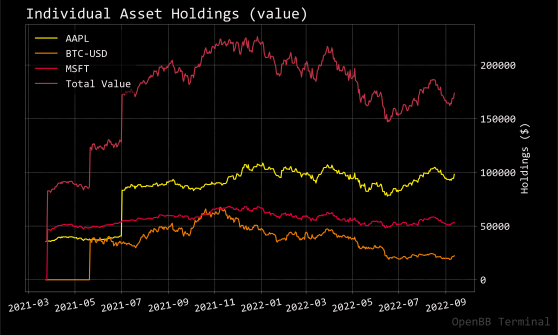

In [6]:
openbb.portfolio.holdv(P, chart=True)

In [7]:
openbb.portfolio.perf(P)

,Portfolio,Benchmark,Difference
Total Investment,162140.0,162140.0,-
Total Value,173788.247681,165903.458391,7884.789289
Total % Return,7.18%,2.32%,4.86%
Total Abs Return,11648.247681,3763.458391,7884.789289


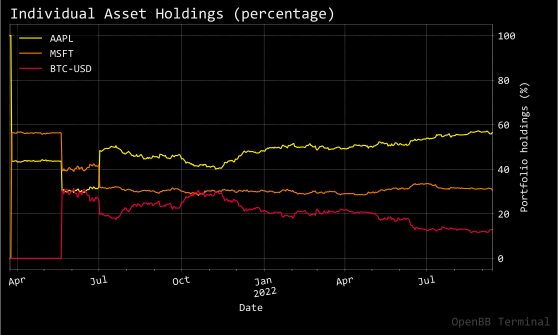

In [8]:
openbb.portfolio.holdp(P, chart=True)

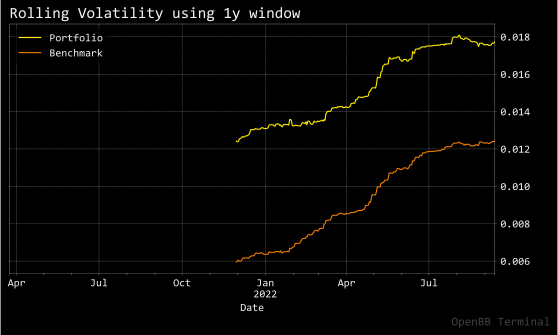

In [9]:
openbb.portfolio.rvol(P, chart=True)

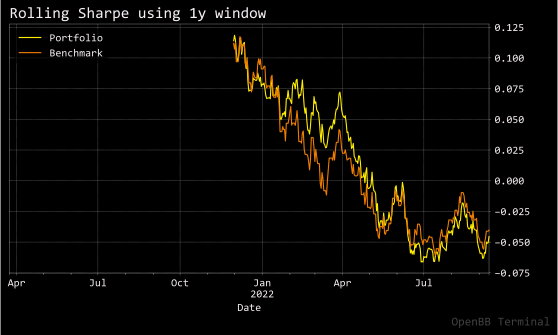

In [10]:
openbb.portfolio.rsharpe(P, chart=True)

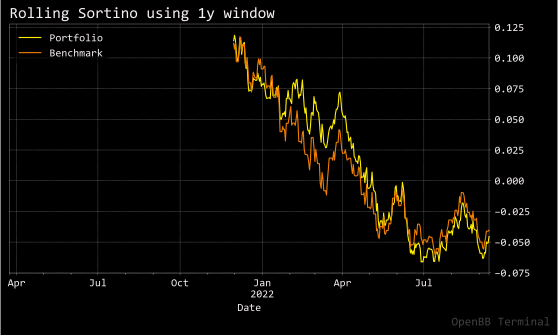

In [11]:
openbb.portfolio.rsortino(P, chart=True)

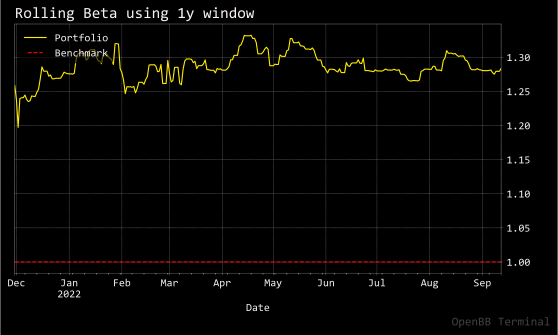

In [12]:
openbb.portfolio.rbeta(P, chart=True)

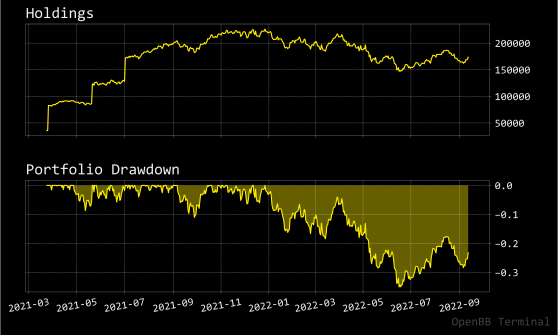

In [13]:
openbb.portfolio.maxdd(P, chart=True)

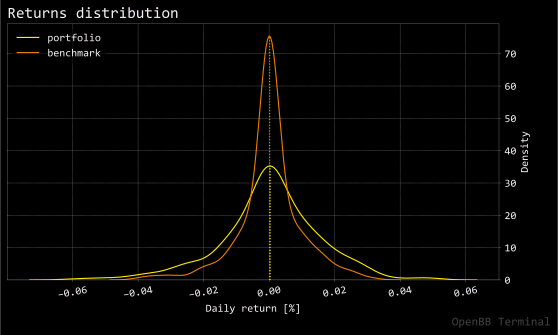

In [14]:
openbb.portfolio.distr(P, chart=True)

In [15]:
openbb.portfolio.var(P)

,VaR,Historical VaR
90.0%,-0.019461,-0.017640
95.0%,-0.024902,-0.027152
99.0%,-0.035028,-0.043105
99.9%,-0.046267,-0.058266


In [16]:
openbb.portfolio.es(P)

,ES,Historical ES
90.0%,-0.026888,-0.030152
95.0%,-0.031613,-0.037505
99.0%,-0.040889,-0.051883
99.9%,-0.051616,-0.059983


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


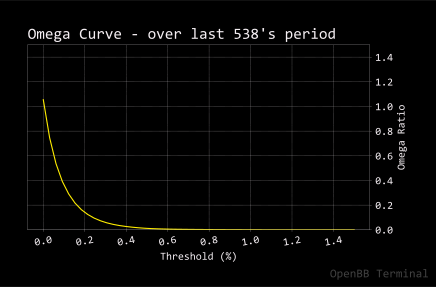

In [17]:
openbb.portfolio.om(P, chart=True)

In [18]:
openbb.portfolio.summary(P)

,Portfolio,Benchmark,Difference
Volatility,0.015327,0.009667,0.005660
Skew,-0.381194,-0.476452,0.095258
Kurtosis,1.553808,2.904860,-1.351052
Maximum Drawdowwn,-0.349934,-0.230100,-0.119834
Sharpe ratio,0.019143,0.018074,0.001070
Sortino ratio,0.025101,0.020304,0.004797
R2 Score,0.624735,0.624735,0.000000


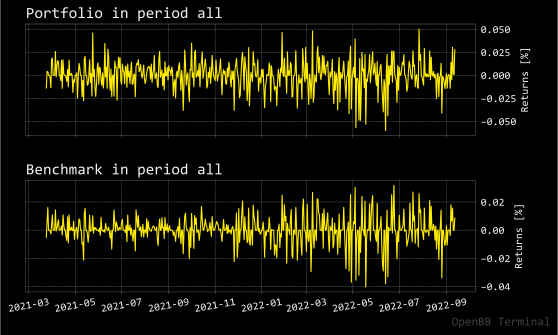

In [19]:
openbb.portfolio.dret(P, chart=True)